
### IMPORTACIÓN DE PAQUETES





In [1]:
#!pip install pystan
#!pip install fbprophet
import fbprophet
from fbprophet import Prophet
import pandas as pd

### DATA

In [2]:
df=pd.read_csv('/content/covid_19.csv')
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [3]:
df.shape

(49068, 10)

In [4]:
df['Date']=pd.to_datetime(df['Date'])

In [5]:
df.isnull().sum()

Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64

In [6]:
df['Date'].nunique()

188

In [7]:
total=df.groupby(['Date'])['Confirmed','Deaths','Recovered','Active'].sum().reset_index()
total.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Date,Confirmed,Deaths,Recovered,Active
0,2020-01-22,555,17,28,510
1,2020-01-23,654,18,30,606
2,2020-01-24,941,26,36,879
3,2020-01-25,1434,42,39,1353
4,2020-01-26,2118,56,52,2010


In [8]:
df_prophet=total.rename(columns={'Date':'ds','Confirmed':'y'})
df_prophet.head()

,ds,y,Deaths,Recovered,Active
0,2020-01-22,555,17,28,510
1,2020-01-23,654,18,30,606
2,2020-01-24,941,26,36,879
3,2020-01-25,1434,42,39,1353
4,2020-01-26,2118,56,52,2010


### MODELO

In [9]:
m=Prophet(interval_width=0.95)
model=m.fit(df_prophet)
model.seasonalities

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OrderedDict([('weekly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 7,
               'prior_scale': 10.0})])

### PREDICCIÓN

#### Paso 1: Crear el dataframe donde colocaremos los resultados

In [18]:
future_global=model.make_future_dataframe(periods=90,freq='D')
future_global.head()

,ds
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26


In [11]:
df_prophet.shape

(188, 5)

In [12]:
future_global.shape

(553, 1)

In [13]:
df_prophet['ds'].tail()

183   2020-07-23
184   2020-07-24
185   2020-07-25
186   2020-07-26
187   2020-07-27
Name: ds, dtype: datetime64[ns]

In [19]:
future_global.tail()

,ds
273,2020-10-21
274,2020-10-22
275,2020-10-23
276,2020-10-24
277,2020-10-25


#### Paso 2: Realizar los pronósticos y guardarlos en forecast

In [20]:
prediction=model.predict(future_global)
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-9.323896e+03,-1.848888e+05,1.308867e+05,-9.323896e+03,-9.323896e+03,-10979.704311,-10979.704311,-10979.704311,-10979.704311,-10979.704311,-10979.704311,0.0,0.0,0.0,-2.030360e+04
1,2020-01-23,-6.626094e+03,-1.686619e+05,1.481181e+05,-6.626094e+03,-6.626094e+03,-1101.212489,-1101.212489,-1101.212489,-1101.212489,-1101.212489,-1101.212489,0.0,0.0,0.0,-7.727307e+03
2,2020-01-24,-3.928293e+03,-1.422694e+05,1.641035e+05,-3.928293e+03,-3.928293e+03,10055.768575,10055.768575,10055.768575,10055.768575,10055.768575,10055.768575,0.0,0.0,0.0,6.127475e+03
3,2020-01-25,-1.230492e+03,-1.549378e+05,1.740022e+05,-1.230492e+03,-1.230492e+03,13728.634691,13728.634691,13728.634691,13728.634691,13728.634691,13728.634691,0.0,0.0,0.0,1.249814e+04
4,2020-01-26,1.467309e+03,-1.572421e+05,1.706538e+05,1.467309e+03,1.467309e+03,7278.808727,7278.808727,7278.808727,7278.808727,7278.808727,7278.808727,0.0,0.0,0.0,8.746118e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2020-10-21,3.368848e+07,2.991321e+07,3.752917e+07,2.994359e+07,3.760606e+07,-10979.704311,-10979.704311,-10979.704311,-10979.704311,-10979.704311,-10979.704311,0.0,0.0,0.0,3.367750e+07
274,2020-10-22,3.389259e+07,3.006926e+07,3.792832e+07,3.011556e+07,3.788155e+07,-1101.212489,-1101.212489,-1101.212489,-1101.212489,-1101.212489,-1101.212489,0.0,0.0,0.0,3.389149e+07
275,2020-10-23,3.409671e+07,3.026826e+07,3.810391e+07,3.026970e+07,3.813893e+07,10055.768575,10055.768575,10055.768575,10055.768575,10055.768575,10055.768575,0.0,0.0,0.0,3.410676e+07
276,2020-10-24,3.430082e+07,3.038701e+07,3.844404e+07,3.040008e+07,3.842134e+07,13728.634691,13728.634691,13728.634691,13728.634691,13728.634691,13728.634691,0.0,0.0,0.0,3.431455e+07


In [21]:
prediction[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
273,2020-10-21,3.367750e+07,2.991321e+07,3.752917e+07
274,2020-10-22,3.389149e+07,3.006926e+07,3.792832e+07
275,2020-10-23,3.410676e+07,3.026826e+07,3.810391e+07
276,2020-10-24,3.431455e+07,3.038701e+07,3.844404e+07
277,2020-10-25,3.451221e+07,3.050574e+07,3.874461e+07


#### Paso 3: Graficar los pronósticos

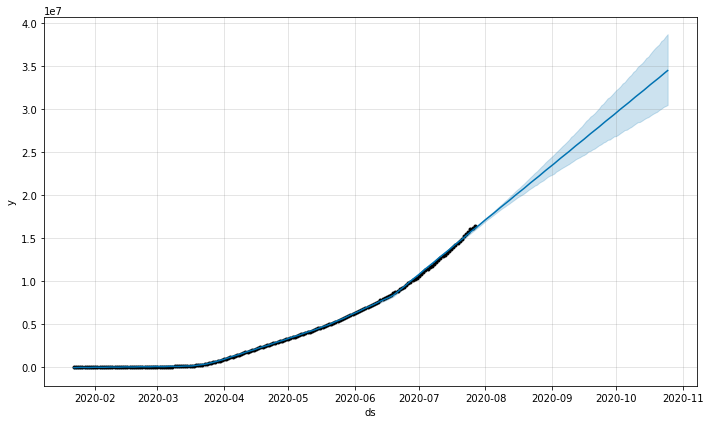

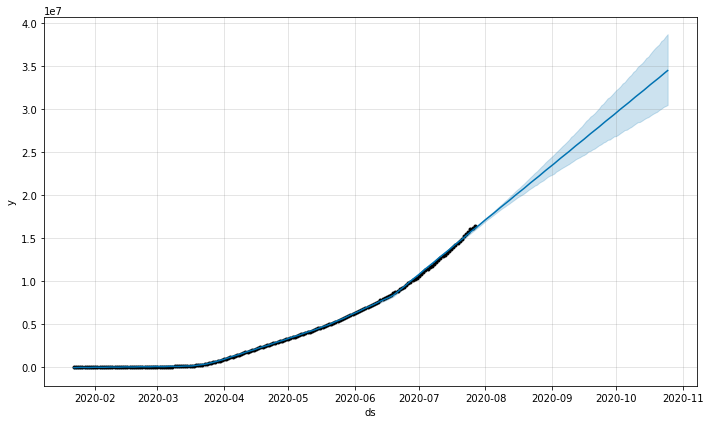

In [22]:
model.plot(prediction)

#### Vizualizazación de Componentes[Trends,Weekly]

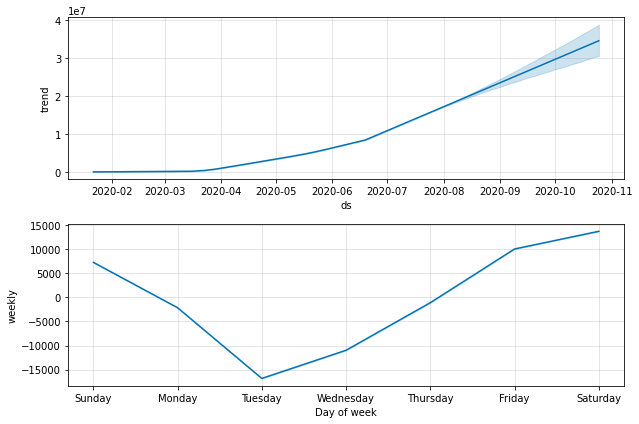

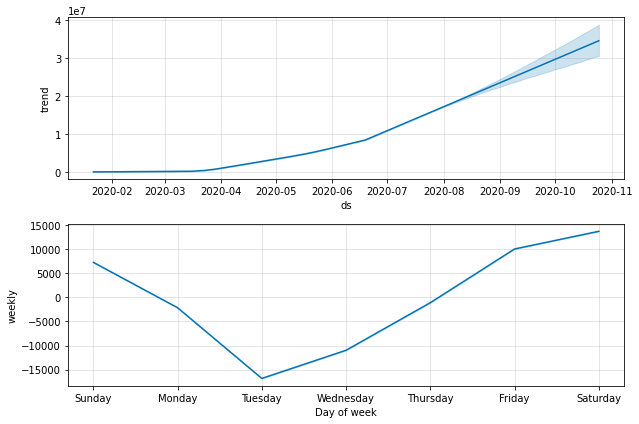

In [23]:
model.plot_components(prediction)

In [24]:
#### The prophet model identifies points at which the trend changes and those can be plotted.¶
from fbprophet.plot import add_changepoints_to_plot

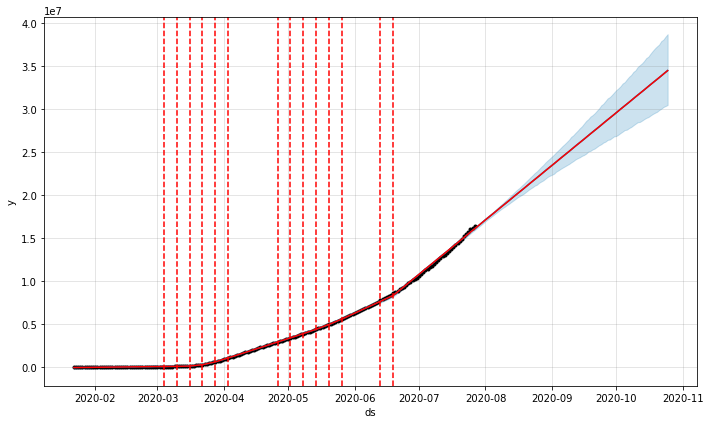

In [25]:
fig=model.plot(prediction)

a=add_changepoints_to_plot(fig.gca(),model,prediction)

In [26]:
from fbprophet.diagnostics import cross_validation

In [27]:
df_cv=cross_validation(model,horizon='30 days',period='15 days',initial='90 days')
## horizon='365 days'--> for how many days we have to cross validate=====

## Computes forecasts from historical cutoff points Beginning from..

## (end - horizon) it means it is going to take that date that is (end - horizon) bcz on these date we have to just 
## cross-validate for the new dataset that we have to find out

## period=180 as from documentation of func as period=0.5*365=180 or {period=1/2*horizon value}
## initial -How many total no. of days we actually want-- 3*365 from documentation of function or  {initial=3*horizon}

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-04-28 00:00:00 and 2020-06-27 00:00:00


In [28]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-04-29,3.201064e+06,3.192140e+06,3.208758e+06,3185195,2020-04-28
1,2020-04-30,3.285432e+06,3.274954e+06,3.295787e+06,3268876,2020-04-28
2,2020-05-01,3.369640e+06,3.348997e+06,3.386983e+06,3355922,2020-04-28
3,2020-05-02,3.450902e+06,3.423009e+06,3.477990e+06,3437608,2020-04-28
4,2020-05-03,3.530365e+06,3.492347e+06,3.567597e+06,3515244,2020-04-28


In [29]:
df_cv.shape

(150, 6)

#### Métricas
    We use the performance_metrics utility to compute the Mean Squared Error(MSE), Root Mean Squared Error(RMSE),Mean Absolute Error(MAE), Mean Absolute Percentage Error(MAPE) and the coverage of the the yhat_lower and yhat_upper estimates.


In [30]:
from fbprophet.diagnostics import performance_metrics

In [31]:
df_performance=performance_metrics(df_cv)
df_performance.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,2.721596e+10,164972.604876,129190.213315,0.016867,0.017675,0.066667
1,4 days,3.770271e+10,194171.855844,151379.846239,0.019330,0.022485,0.133333
2,5 days,5.170151e+10,227379.657369,175214.816680,0.021780,0.025717,0.200000
3,6 days,6.937441e+10,263390.225361,202192.647173,0.024558,0.026714,0.200000
4,7 days,9.012810e+10,300213.430311,232530.254272,0.027838,0.031274,0.200000


In [32]:
from fbprophet.plot import plot_cross_validation_metric

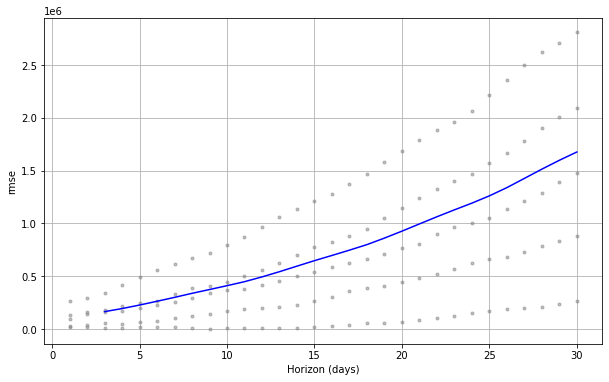

In [33]:
df_performance=plot_cross_validation_metric(df_cv,metric='rmse')

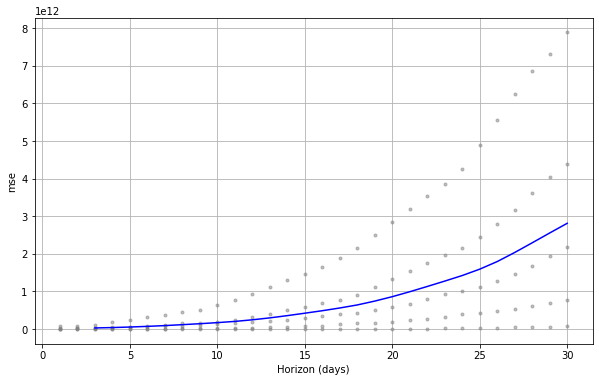

In [34]:
df_performance=plot_cross_validation_metric(df_cv,metric='mse')

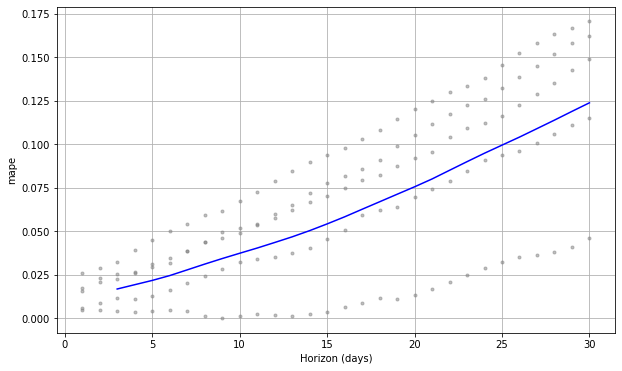

In [35]:
df_performance=plot_cross_validation_metric(df_cv,metric='mape')